In [1]:
###
# Idea for pretty art from images. 
# image is gaussian blurred into a potential, 
#lines emerge from edges and are attracted to the image basin. Lines per channel 

In [1]:
import os
from math import sqrt, pow, cos, sin, pi
import copy, pickle, random
from xml.dom import minidom

import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate

import imageio
from PIL import Image

import svgwrite

from lineifiers import * 
from svg_tools import *
from plotter import * 
%matplotlib inline

No Adafruit modules found.
Board not supported None
I'm a mock plotter now.


In [2]:
cymk_lines = svg_to_paths('fox.svg')

Converting 5 paths


In [27]:
with open("parsed.pkl",'wb') as f: 
    pickle.dump(cymk_lines,f)

In [3]:
write_svg(cymk_lines[-1])

In [4]:
def paths_bounds(paths):
    """
    returns xmin, ymin, xmax, ymax 
    """
    if (not type(paths)==list):
        return [0.,0.,200.,200.]
    L = [path_bounds(X) for X in paths if len(X)>=2]
    if (len(L)==0):
        return [0.,0.,200.,200.]
    A = np.array(L)
    return A[:,:2].min(0).tolist()+A[:,2:].max(0).tolist()
def cymk_bounds(cymk):
        A=np.array([paths_bounds(cymk[0]),
        paths_bounds(cymk[1]),
        paths_bounds(cymk[2]),
        paths_bounds(cymk[3])])
        return A[:,:2].min(0).tolist()+A[:,2:].max(0).tolist()
preamble = """; Totem // SongShine // USongShine // MakeBlock Laserbox 
; MKS DLC 2.0 Based Laser control test program. 
; Written by hand with love, by john.parkhill@gmail.com
;
; setup 
G90         ; Absolute positioning
G21         ; Set units to mm

$0=10      ; step pulse (micro s) 
$1=25     
$2=0        ; Don't invert X
$3=0
$4=0
$5=0
$6=0
$10=1
$11=0.010
$12=0.002
$13=0
$20=0
$21=0
$22=0 ; disable homing. 
$23=0
$24=25.000
$25=500.000
$26=250
$27=1.000
$30=1000 ; max spindle speed RPM
$31=0 ; max spindle speed RPM
$100=83.439 ; xsteps /mm
$101=83.439 ; ysteps /mm
$102=250.000; zsteps /mm
$110=400.000; x Max Rate mm/min
$111=400.000; y Max Rate mm/min
$112=200.000; z Max Rate mm/min
$120=6000.000; x accel (mm/sec^2)
$121=6000.000; y accel (mm/sec^2)
$122=10.000; z accel (mm/sec^2)
$130=200.000; x max travel (mm) 
$131=200.000; y max travel (mm) 
$132=200.000; z max travel (mm) 

$32=1      ; enter GRBL 1.1 laser mode
M3           ; const mode 
M4           ; dynamic mode 
"""    
def lines_to_gcode(paths, target_width = 180., rate=250.0, 
                   power=400., outfile = 'plot.gcode'): 
    """
    Writes monochrome lines to a gcode with desired scaling. 
    Flips X-axis because of the geometry of my plotter. 
    """
    bnds = paths_bounds(paths)
    width = (bnds[2]-bnds[0])
    scale_factor = target_width/width
    # Reflect the x-coordinate first 
    def map_x(x):
        return ((-1.*(x-width/2.))+width/2.)*scale_factor
    def map_y(y): 
        return (y-bnds[1])*scale_factor
    # Write the boundary size to screen. 
    print("Plot Size (cm): {:f}x{:f}".format(map_x(bnds[0]), map_y(bnds[3])))
    with open("bounds_"+outfile,'w') as f:
        for line in preamble: 
            f.write(line)
        f.write("G1 X{:0.3f} Y{:0.3f} S0 F{:0.3f}\n".format(map_x(bnds[0]), 
                                                            map_y(bnds[1]),rate))
        f.write("G1 X{:0.3f} Y{:0.3f} S{:0.3f} F{:0.3f}\n".format(map_x(bnds[2]), 
                                                                  map_y(bnds[1]),
                                                                  power, rate))
        f.write("G1 X{:0.3f} Y{:0.3f} S{:0.3f} F{:0.3f}\n".format(map_x(bnds[2]), 
                                                                  map_y(bnds[3]),
                                                                  power, rate))
        f.write("G1 X{:0.3f} Y{:0.3f} S{:0.3f} F{:0.3f}\n".format(map_x(bnds[0]), 
                                                                  map_y(bnds[3]),
                                                                  power, rate))
        f.write("G1 X{:0.3f} Y{:0.3f} S{:0.3f} F{:0.3f}\n".format(map_x(bnds[0]), 
                                                                  map_y(bnds[1]),
                                                                  power, rate))
        f.write("G1 X{:0.3f} Y{:0.3f} S0 F{:0.3f}\n".format(0,0,rate))
    with open(outfile,'w') as f:
        for line in preamble: 
            f.write(line)
        for path in paths: 
            if len(path) < 2: 
                continue
            X,Y = path[0]
            f.write("G1 X{:0.3f} Y{:0.3f} S0 F{:0.3f}\n".format(map_x(X), map_y(Y), rate))
            for i,p in enumerate(path[1:]): 
                X,Y = p 
                f.write("G1 X{:0.3f} Y{:0.3f} S{:0.3f} F{:0.3f}\n".format(map_x(X), 
                                                            map_y(Y), power, rate))
        f.write("G1 X{:d} Y{:d} S0 F{:0.3f}\n".format(0,0,rate))
    return 

In [5]:
lines_to_gcode(cymk_lines[3], power=500., target_width=150.)

Plot Size (cm): 145.910212x116.677632


In [17]:
lines_to_gcode(cymk_lines[0]+cymk_lines[2]+cymk_lines[3])

In [18]:

def test_gcode(linelength = 15, nlines = 5.,  
                lineseps = [1.,2,4],
                Ss = [50.,100,200,400,1000],
                Fs = [50.,100,200,300,400], 
                total_size = 200, outfile='test'): 
    """
    Draws a test pattern.
    """
    bnds = [0,0,1,1]
    map_x = lambda x: x*total_size
    map_y = lambda y: y*total_size    
    with open("bounds_"+outfile,'w') as f:
        for line in preamble: 
            f.write(line)
        f.write("G1 X{:d} Y{:d} S0 F400\n".format(map_x(bnds[0]), map_y(bnds[1])))
        f.write("G1 X{:d} Y{:d} S1000 F400\n".format(map_x(bnds[2]), map_y(bnds[1])))
        f.write("G1 X{:d} Y{:d} S1000 F400\n".format(map_x(bnds[2]), map_y(bnds[3])))
        f.write("G1 X{:d} Y{:d} S1000 F400\n".format(map_x(bnds[0]), map_y(bnds[3])))
        f.write("G1 X{:d} Y{:d} S1000 F400\n".format(map_x(bnds[0]), map_y(bnds[1])))
        f.write("G1 X{:d} Y{:d} S0 F400\n".format(0,0))    
    
    sepsize = 1./len(lineseps)
    sep_ymaxs = [float(i*sepsize) for i in range(len(lineseps))]
    
    Ssize = 1./len(Ss)
    S_xmaxs = [float(i*Ssize) for i in range(len(Ss))]
    
    
    insep_yshifts = 
    
    with open("bounds_"+outfile,'w') as f:
        for ls in lineseps: 
            for S in Ss: 
                for F in Fs 

SyntaxError: invalid syntax (<ipython-input-18-72e0f405b0e1>, line 30)

In [ ]:
with open("hand.pkl",'wb') as f: 
    pickle.dump(cymk_lines,f)

In [1]:
files = os.listdir('/Users/johnparkhill/Little_Projects/art_for_lines/img_files')

NameError: name 'os' is not defined

In [2]:
files

NameError: name 'files' is not defined

In [14]:
rootdir = '/Users/johnparkhill/Little_Projects/art_for_lines/img_files/'
im_arrays=[]
for X in files: 
    if X.count("jpg")>0: 
        with open(rootdir+X,'rb') as f: 
            im_arrays.append(imageio.imread(f))

In [15]:
files

['download.jpeg',
 'stalkerII.svg',
 'golden-opportunity-chris-ware.jpg',
 '.DS_Store',
 'bob_le_flambeur-900.jpg',
 '81E3dK1i3-L._SL1500_.jpg',
 'dodge.jpeg',
 'stalker-1979-002-00m-ln4-dog-running-through-water_0.jpg',
 '2046-zhangziyi-feature-1600x900-c-default.jpg',
 'gokudo-kyofu-dai-gekijo-gozu-german-dvd-movie-cover.jpg',
 '23405756_1890470151282571_8743520120236682996_o.jpg',
 'WareObserver.jpg',
 'HBeG5.jpg',
 'e62edc39b7fafd0edf295b833bbcc5a3.jpg',
 'worstdays.jpg',
 'chin.jpg',
 'images-w1400.jpg',
 'LDurieux_Conversation_Var_Sm_1024x1024.png',
 'jobbetter.jpg',
 'palaceoffinearts.jpg',
 'tJaeWoH1UJPyeIU2yd9YJgeghFC.jpg',
 'challenger-vanishing-point-ranch.jpg',
 'otto-e-mezzo-8-1-2-movie-fellini-eleven.png',
 'ware-monograph.jpg',
 '2046.jpg',
 'ware-detail-6-1wes.jpg',
 'bettertomorrow.jpg',
 'img_1298.jpg',
 'tumblr_mm7nxgTLy61s8dmv9o5_1280.png']

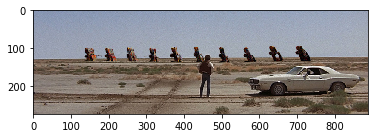

In [16]:
img = im_arrays[-6]
plt.imshow(img)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


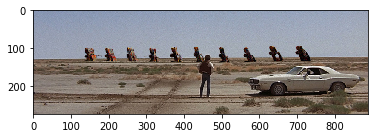

In [17]:
x = np.linspace(0,img.shape[0],img.shape[0])
y = np.linspace(0,img.shape[1],img.shape[1])
#
# 2x oversample the image since we'll dither it. 
#
oversamp = 1.0
xnew = np.linspace(0, img.shape[0], img.shape[0]*oversamp)
ynew = np.linspace(0, img.shape[1], img.shape[1]*oversamp)
rc = interpolate.interp2d(x, y, img[:,:,0].flatten(), kind='linear')
gc = interpolate.interp2d(x, y, img[:,:,1].flatten(), kind='linear')
bc = interpolate.interp2d(x, y, img[:,:,2].flatten(), kind='linear')
rgb_new = np.stack([rc(xnew.flatten(), ynew.flatten()),
                    gc(xnew.flatten(), ynew.flatten()),
                    bc(xnew.flatten(), ynew.flatten())],-1).transpose(1,0,2).astype(np.uint8)
plt.imshow(rgb_new)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


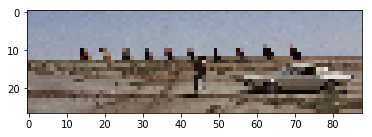

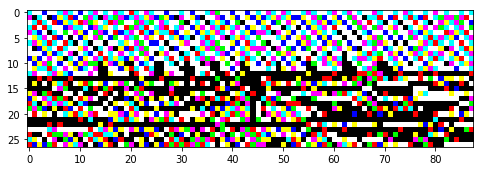

In [18]:
x = np.linspace(0,img.shape[0],img.shape[0])
y = np.linspace(0,img.shape[1],img.shape[1])
#
# 2x oversample the image since we'll dither it. 
#
oversamp = 0.1
xnew = np.linspace(0, img.shape[0], img.shape[0]*oversamp)
ynew = np.linspace(0, img.shape[1], img.shape[1]*oversamp)
rc = interpolate.interp2d(x, y, img[:,:,0].flatten(), kind='linear')
gc = interpolate.interp2d(x, y, img[:,:,1].flatten(), kind='linear')
bc = interpolate.interp2d(x, y, img[:,:,2].flatten(), kind='linear')
rgb_new = np.stack([rc(xnew.flatten(), ynew.flatten()),
                    gc(xnew.flatten(), ynew.flatten()),
                    bc(xnew.flatten(), ynew.flatten())],-1).transpose(1,0,2).astype(np.uint8)
plt.imshow(rgb_new)
# cymk_new = rgb_to_cymk(rgb_new)
dith_r = floyd_steinberg(rgb_new)
plt.figure(figsize=(8,10))
plt.imshow((255*dith_r).astype(np.uint8))

In [20]:
dithered = floyd_steinberg(rgb_new)
# Because the dithered output is already between 0,1
cymk_new = rgb_to_cmyk(dithered, RGB_SCALE=1.)
c_lines, y_lines, m_lines, k_lines = random_ngon_linify(cymk_new, n_max=5,r_max = 1.5)
cymk_lines = [c_lines, y_lines, m_lines, k_lines]
write_svg(k_lines, "bw_lines.svg", scale=10.)
cymk_to_svg(cymk_lines,scale=5.)

In [43]:
with open("palace.pkl",'wb') as f: 
    pickle.dump(cymk_lines,f)

In [10]:
with open("palace.pkl",'wb') as f: 
    pickle.dump(k_lines,f)

In [11]:
with open("img.pkl",'rb') as f: 
    X=pickle.load(f)
write_svg(X)

In [ ]:
# Check the SVG before plotting it out. 
write_svg([P])

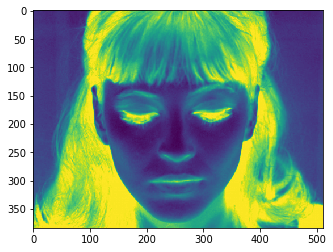

(384, 511)


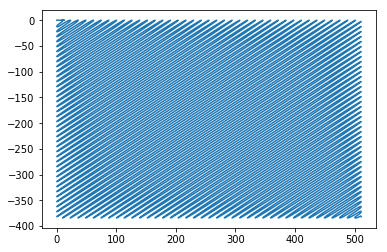

[511. 384.]
(125200, 2)


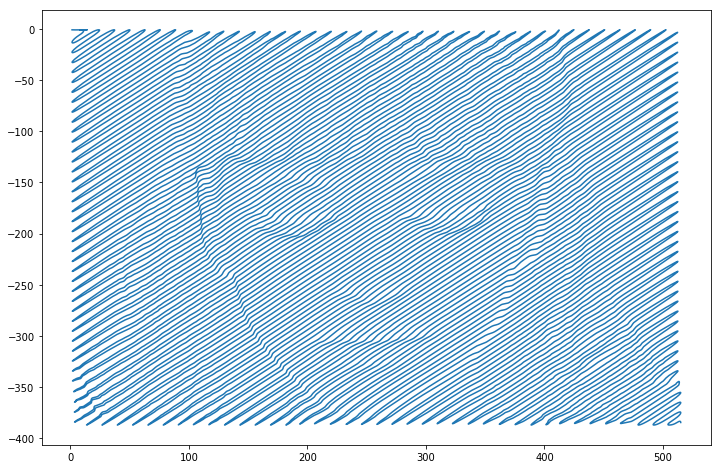

In [414]:
img = rgb_to_cmyk(rgb_new, RGB_SCALE=255.)[:,:,-1]
plt.imshow(img)
plt.show()
print(img.shape)
y = np.linspace(0, img.shape[0], img.shape[0])
x = np.linspace(0, img.shape[1], img.shape[1])
F = interpolate.interp2d(y, x, img.flatten(), kind='linear')
sharp_wiggle = wiggle_fill((0,img.shape[1]), (0,img.shape[0]), nwiggle=80)
# plt.plot(np.array(sharp_wiggle)[:,0],-1*np.array(sharp_wiggle)[:,1])
# plt.show()
list_wiggle=np.array(sharp_wiggle).reshape(-1,2)
wiggle = smooth_path(list_wiggle)
plt.plot(np.array(wiggle)[:,0],-1*np.array(wiggle)[:,1])
plt.show()
print(np.array(wiggle).max(0))
new_path = smooth_path(np.array(path_channel_distort(wiggle, F)).reshape(-1,2),window=4)
P = np.array(new_path).reshape(-1,2)
print(P.shape)
plt.figure(figsize=(12,8))
plt.plot(P[:,0],-1*P[:,1])
# plt.plot(P[:,1]-P[:,1].min(),-1*P[:,0]+P[:,0].max())
plt.show()

In [368]:
# Check the SVG before plotting it out. 
write_svg([P])

In [371]:
with open("jobbetter.pkl",'rb') as f: 
    X=pickle.load(f)
write_svg(X)

In [370]:
with open("jobbetter.pkl",'wb') as f: 
    pickle.dump([P],f)

In [49]:
cymk_to_svg(cymk_lines,scale=5.)

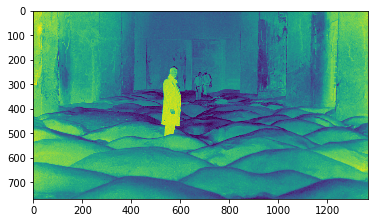

In [56]:
cymk = rgb_to_cmyk(img)
plt.imshow(cymk[:,:,-1])

In [463]:
cymk = rgb_to_cmyk(img)
# cc = interpolate.interp2d(x, y, cymk[:,:,0].flatten(), kind='linear')
# yc = interpolate.interp2d(x, y, cymk[:,:,1].flatten(), kind='linear')
# mc = interpolate.interp2d(x, y, cymk[:,:,2].flatten(), kind='linear')
x = np.linspace(0,img.shape[0],img.shape[0])
y = np.linspace(0,img.shape[1],img.shape[1])
kc = interpolate.interp2d(x, y, cymk[:,:,3].flatten(), kind='linear')
# c_lines = grid_lineify(cc, x_lim=(0, img.shape[0]), y_lim=(0, img.shape[1]),ntraj = 1000)
# y_lines = grid_lineify(yc, x_lim=(0, img.shape[0]), y_lim=(0, img.shape[1]),ntraj = 500)
# m_lines = grid_lineify(mc, x_lim=(0, img.shape[0]), y_lim=(0, img.shape[1]),ntraj = 1000)
k_lines = grid_lineify(kc, x_lim=(0, img.shape[0]), y_lim=(0, img.shape[1]), 
            ntraj = 1500, 
            max_step = 4000, gamma = 0.08, dt = 9., e0 = 0.03, 
            T = 0.1, e_thresh = 0.006, h = 2e-1, m = 6, bounce = False)

NameError: name 'grid_lineify' is not defined

In [61]:
with open("stalkerII",'wb') as f: 
    pickle.dump(k_lines,f)

In [60]:
write_svg(k_lines, scale=3.0)

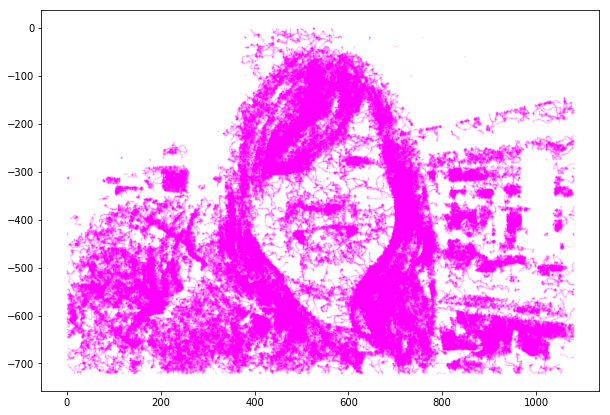

In [1117]:
plt.figure(figsize=(10,7))
# for line in c_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='cyan')
# for line in y_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='yellow')
# for line in m_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='magenta')
for line in k_lines: 
    if (len(line)<1):
        continue 
    t1 = np.array(line)
    _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.1, color='black')    
plt.show()

In [190]:
pl = Plotter()

Initializing I2C... 
Initializing pen...
Move pen to start and press ENTER.

Print area:  (2.0, 89.44) (2.0, 57.2)
Step Lengt:  0.15707963267948966
Min Resolu:  556.0  X  351.0
Line Files:
10 stalkerlines.pkl
--- Selection ---
10
Load Pen.
Initializing pen...
Move pen to start and press ENTER.

Data Bounds:  [0.021159459344625514, 0.004511756825272828, 802.9934998713557, 999.9992398531366]
Scaling Data....
Scaled Data. [23.779468102211165, 2.2759999999999962, 67.66053189778883, 56.92400000000001]
Planning  36  paths.
drawing...
Drawing  5  vertices 
took  7.434473276138306 s
Drawing  98  vertices 
took  3.4249379634857178 s
Drawing  83  vertices 
took  2.6103789806365967 s
Drawing  57  vertices 
took  1.49593186378479 s
Drawing  154  vertices 
took  4.452978849411011 s
Drawing  1274  vertices 
took  18.930482149124146 s
Drawing  1583  vertices 
took  19.24885392189026 s
Drawing  55  vertices 
took  1.838973045349121 s
Drawing  8  vertices 
took  1.1161220073699951 s
Drawing  342  verti

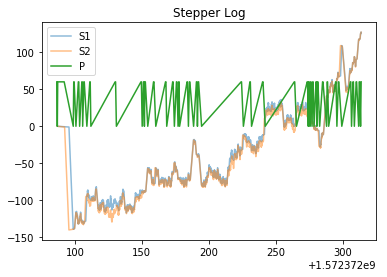

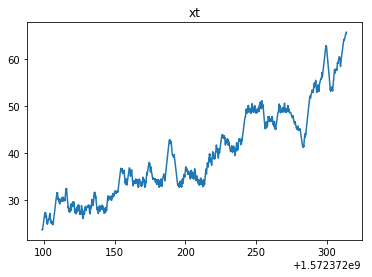

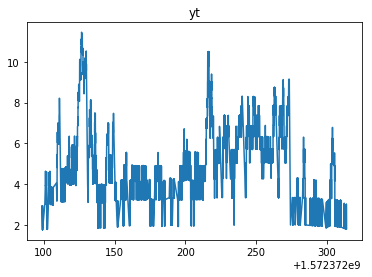

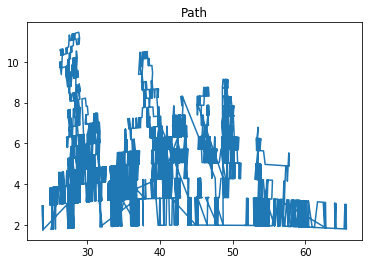

In [191]:
pl.plot_paths()

In [158]:
# https://picsvg.com/
def svg_to_paths(filename = 'drawing.svg'):
    tore = [[],[],[],[]] # Cymk lines. 
    xmldoc = minidom.parse(filename)
    
    xmldoc.getElementsByTagName('g')
    
    itemlist = xmldoc.getElementsByTagName('path')
    print("Converting", len(itemlist),"paths")
    for spath in itemlist: 
        if(not 'd' in spath.attributes): 
            continue
        # Get any required transformations. 
        if ('transform' in spath.attributes):
            coord_xform = parse_transform(spath.attributes['transform'].value)
        else: 
            coord_xform = ident_xform
        if ('id' in spath.attributes): 
            id_ = spath.attributes['id'].value
        else: 
            id_ = None
        if (len(spath.attributes['d'].value)>2):
            try: 
                tore[-1].append(svg_path_outline(spath.attributes['d'].value, coord_xform))
            except Exception as Ex: 
                print("Bad path", id_)
                print(Ex)
                raise Ex
    return tore

def parse_transform(t): 
    if 'scale' in t: 
        scl = float(t.replace('scale(','').replace(')',''))
        tore = lambda X: scale_xform(X, scl = scl)
    elif 'matrix' in t: 
        meles = t.replace('matrix(','').replace(')','').replace(',',' ')
        a,b,c,d,e,f = list(map(float,meles))
        return lambda X: [a*X[0]+b*X[1]+c, d*X[0]+e*X[1]+f]
    else: 
        tore = ident_xform
    return tore

def scale_xform(X,scl = 1.0): 
    return [scl*X[0], scl*X[1]]
    
def ident_xform(X): 
    return [X[0],X[1]]
    
def svg_path_outline(a_path, out_path, xform = ident_xform,  X=0 , Y=0, bezier_steps = 10 ): 
    """
    Takes the 'd' attribute of a path. 
    """
    X0, Y0 = X,Y
    tokens = [Z for Z in a_path.replace(',',' ').split(' ') if len(Z)>0]
    tokens_orig = [Z for Z in a_path.replace(',',' ').split(' ') if len(Z)>0]
    out_path = []
    used_tokens = []
    token = None
    while (len(tokens)>0):
        used_tokens.append(token)
        token = tokens.pop(0)    
        if (token == 'm'):
            while (len(tokens)>0):
                if tokens[0].isalpha():
                    break
                X += float(tokens.pop(0))
                Y += float(tokens.pop(0))
            X0,Y0 = X,Y
            continue
        elif (token == 'M'):
            X = float(tokens.pop(0))
            Y = float(tokens.pop(0))
            X0,Y0 = X,Y            
            continue            
        elif (token == 'l'):
            while (len(tokens)>0):
                if tokens[0].isalpha():
                    break
                # Simple line
                out_path.append([X,Y])
                X += float(tokens.pop(0))
                Y += float(tokens.pop(0))
                out_path.append([X,Y])
        elif (token == 'L'):
            while (len(tokens)>0):
                if tokens[0].isalpha():
                    break
                # Simple line
                out_path.append([X,Y])
                X = float(tokens.pop(0))
                Y = float(tokens.pop(0))
                out_path.append([X,Y])              
        elif (token == 'z'):
            # close the contour
            out_path.append([X,Y])
            out_path.append([X0,Y0])
            X,Y = X0, Y0
        elif (token == 'h'):
            # close the contour
            out_path.append([X,Y])
            X += float(tokens.pop(0))
            out_path.append([X,Y])
        elif (token == 'v'):
            # close the contour
            out_path.append([X,Y])
            Y += float(tokens.pop(0))
            out_path.append([X,Y])
        elif (token == 'c'):
            try: 
                while (len(tokens)>0):
#                     print("T", token, tokens)
                    if tokens[0].isalpha():
                        break
                    # Simple line
                    out_path.append([X,Y])
                    p0x = X
                    p0y = Y
                    C1x = X + float(tokens.pop(0))
                    C1y = Y + float(tokens.pop(0))
                    C2x = X + float(tokens.pop(0))
                    C2y = Y + float(tokens.pop(0))                
                    X += float(tokens.pop(0))
                    Y += float(tokens.pop(0))
                    for t in [1.*X/bezier_steps for X in range(1,bezier_steps+1)]: 
                        omt = 1.-t
                        Xp = pow(omt,3)*p0x + 3*pow(omt,2.)*t*C1x + 3*pow(t,2.)*omt*C2x+pow(t,3)*X
                        Yp = pow(omt,3)*p0y + 3*pow(omt,2.)*t*C1y + 3*pow(t,2.)*omt*C2y+pow(t,3)*Y
                        out_path.append([Xp,Yp])
            except Exception as Ex: 
                print(tokens)
                print(used_tokens)
                raise Ex
        else: 
            print('BAD TOKEN', token, used_tokens[-1])
            raise Exception('Bad Token')
    return list(map(xform, out_path))

In [151]:
svg_to_paths()

Converting 119 paths


[[],
 [],
 [],
 [[[1313.0, 4478.0],
   [1304.2590000000002, 4475.590000000001],
   [1296.5920000000003, 4473.120000000001],
   [1289.9329999999998, 4470.53],
   [1284.2160000000001, 4467.76],
   [1279.375, 4464.75],
   [1275.344, 4461.4400000000005],
   [1272.057, 4457.7699999999995],
   [1269.448, 4453.68],
   [1267.451, 4449.110000000001],
   [1266.0, 4444.0],
   [1266.0, 4444.0],
   [1264.7150000000001, 4440.169000000001],
   [1263.2800000000002, 4436.512000000001],
   [1261.7249999999997, 4433.083],
   [1260.0800000000002, 4429.936000000001],
   [1258.375, 4427.125],
   [1256.64, 4424.704000000001],
   [1254.905, 4422.727],
   [1253.2, 4421.248],
   [1251.555, 4420.321],
   [1250.0, 4420.0],
   [1250.0, 4420.0],
   [1246.036, 4417.616000000001],
   [1243.1280000000002, 4411.008000000001],
   [1241.2519999999997, 4400.991999999999],
   [1240.384, 4388.384000000001],
   [1240.5, 4374.0],
   [1241.576, 4358.656],
   [1243.588, 4343.168],
   [1246.5120000000002, 4328.352000000001],
   

In [159]:
cymk_lines = svg_to_paths()
cymk_to_svg(cymk_lines,scale=5.)

Converting 63 paths


In [160]:
xmldoc = minidom.parse('drawing.svg')
itemlist = xmldoc.getElementsByTagName('path')

In [194]:
xmldoc.getElementsByTagName('g')

[<DOM Element: g at 0x12ea99898>, <DOM Element: g at 0x12ea999c8>]

In [244]:
def parse_group_into_lines(g, lines, x_form_ = ident_xform, fill_style ='outline', fill_color=[0,0,0]): 
    if ('transform' in g.attributes):
        XF = parse_transform(g.attributes['transform'].value)
        x_form = lambda X: XF(x_form_(X))
    else: 
        x_form = x_form_
    for child in g.childNodes:
        if (child.nodeName=='g'): 
            parse_group_into_lines(child, lines, x_form, fill_style=fill_style, fill_color=fill_color)
        elif (child.nodeName=='path'):
            parse_path_into_lines(child, lines, x_form, fill_style=fill_style, fill_color=fill_color)

def parse_transform(t): 
    if 'scale' in t: 
        scl = float(t.replace('scale(','').replace(')',''))
        tore = lambda X: scale_xform(X, scl = scl)
    elif 'matrix' in t: 
        meles = t.replace('matrix(','').replace(')','').replace(',',' ').split(' ')
        a,b,c,d,e,f = list(map(float,meles))
        return lambda X: [a*X[0]+c*X[1]+e, b*X[0]+d*X[1]+f]
    else: 
        tore = ident_xform
    return tore

def scale_xform(X,scl = 1.0): 
    return [scl*X[0], scl*X[1]]
    
def ident_xform(X): 
    return [X[0],X[1]]            
            
def parse_path_into_lines(a_path_, lines, x_form_ = ident_xform,  
                                   fill_style ='outline', fill_color=[0,0,0],
                                       X=0 , Y=0, bezier_steps = 10 ): 
    """
    Takes the 'd' attribute of a path. 
    """
    # Check for any xform of the path
    if(not 'd' in a_path_.attributes): 
        return
    else: 
        a_path = a_path_.attributes['d'].value
    # Get any required transformations. 
    if ('transform' in a_path_.attributes):
        XF = parse_transform(a_path_.attributes['transform'].value)
        x_form = lambda X: XF(x_form_(X))
    else: 
        x_form = x_form_
    X0, Y0 = X,Y
    tokens = [Z for Z in a_path.replace(',',' ').split(' ') if len(Z)>0]
    tokens_orig = [Z for Z in a_path.replace(',',' ').split(' ') if len(Z)>0]
    out_paths = []
    current_path = []
    token = None
    while (len(tokens)>0):
        token = tokens.pop(0)    
        if (token == 'm'):
            if (len(current_path)>0):
                out_paths.append(copy.copy(current_path))
                current_path = []
            while (len(tokens)>0):
                if tokens[0].isalpha():
                    break
                X += float(tokens.pop(0))
                Y += float(tokens.pop(0))
            X0,Y0 = X,Y
            continue
        elif (token == 'M'):
            if (len(current_path)>0):
                out_paths.append(copy.copy(current_path))
                current_path = []            
            X = float(tokens.pop(0))
            Y = float(tokens.pop(0))
            X0,Y0 = X,Y            
            continue            
        elif (token == 'l'):
            while (len(tokens)>0):
                if tokens[0].isalpha():
                    break
                # Simple line
                current_path.append(x_form([X,Y]))
                X += float(tokens.pop(0))
                Y += float(tokens.pop(0))
                current_path.append(x_form([X,Y]))
        elif (token == 'L'):
            while (len(tokens)>0):
                if tokens[0].isalpha():
                    break
                # Simple line
                current_path.append(x_form([X,Y]))
                X = float(tokens.pop(0))
                Y = float(tokens.pop(0))
                current_path.append(x_form([X,Y]))
        elif (token == 'z'):
            # close the contour
            current_path.append(x_form([X,Y]))
            current_path.append(x_form([X0,Y0]))
            X,Y = X0, Y0
        elif (token == 'h'):
            # close the contour
            current_path.append(x_form([X,Y]))
            X += float(tokens.pop(0))
            current_path.append(x_form([X,Y]))
        elif (token == 'v'):
            # close the contour
            current_path.append(x_form([X,Y]))
            Y += float(tokens.pop(0))
            current_path.append(x_form([X,Y]))
        elif (token == 'c'):
            try: 
                while (len(tokens)>0):
#                     print("T", token, tokens)
                    if tokens[0].isalpha():
                        break
                    # Simple line
                    current_path.append(x_form([X,Y]))
                    p0x = X
                    p0y = Y
                    C1x = X + float(tokens.pop(0))
                    C1y = Y + float(tokens.pop(0))
                    C2x = X + float(tokens.pop(0))
                    C2y = Y + float(tokens.pop(0))                
                    X += float(tokens.pop(0))
                    Y += float(tokens.pop(0))
                    for t in [1.*X/bezier_steps for X in range(1,bezier_steps+1)]: 
                        omt = 1.-t
                        Xp = pow(omt,3)*p0x + 3*pow(omt,2.)*t*C1x + 3*pow(t,2.)*omt*C2x+pow(t,3)*X
                        Yp = pow(omt,3)*p0y + 3*pow(omt,2.)*t*C1y + 3*pow(t,2.)*omt*C2y+pow(t,3)*Y
                        current_path.append(x_form([Xp,Yp]))
            except Exception as Ex: 
                print(tokens)
                print(used_tokens)
                raise Ex
        else: 
            print('BAD TOKEN', token, used_tokens[-1])
            raise Exception('Bad Token')
    if (len(current_path)>0):
        out_paths.append(copy.copy(current_path))
    return lines[-1].extend(out_paths)

# https://picsvg.com/
def svg_to_paths(filename = 'drawing.svg'):
    tore = [[],[],[],[]] # Cymk lines. 
    xmldoc = minidom.parse(filename)
    itemlist = xmldoc.getElementsByTagName('path')
    print("Converting", len(itemlist),"paths")
    lines = [[],[],[],[]]
    for child in xmldoc.childNodes[0].childNodes: 
        if (child.nodeName=='g'):
            parse_group_into_lines(child, lines, x_form_ = ident_xform, 
                                    fill_style ='outline', fill_color=[0,0,0])
        elif (child.nodeName=='path'):
            parse_path_into_lines(child, lines, x_form_ = ident_xform, 
                                    fill_style ='outline', fill_color=[0,0,0]) 
    return lines 

In [236]:
svg_to_paths()

Converting 57 paths


[[],
 [],
 [],
 [[[67.19674014, 76.25733116],
   [66.88837706502001, 76.34235060979998],
   [66.61790232576001, 76.42948672639997],
   [66.38298758874, 76.5208561766],
   [66.18130452048001, 76.61857562719999],
   [66.0105247875, 76.724761745],
   [65.86832005632, 76.84153119679999],
   [65.75236199346, 76.97100064940003],
   [65.66032226544002, 77.1152867696],
   [65.58987253878, 77.27650622419998],
   [65.53868448, 77.45677567999999],
   [65.53868448, 77.45677567999999],
   [65.49335253270002, 77.59192485517997],
   [65.44272891840001, 77.72093569663997],
   [65.38787197049999, 77.84190320426],
   [65.3298400224, 77.95292237791998],
   [65.2696914075, 78.0520882175],
   [65.20848445920001, 78.13749572287998],
   [65.14727751090001, 78.20723989394],
   [65.087128896, 78.25941573056002],
   [65.0290969479, 78.29211823262],
   [64.97424000000001, 78.3034424],
   [64.97424000000001, 78.3034424],
   [64.83439888008, 78.38754462751996],
   [64.73181109584002, 78.62066019775997],
   [64.665

In [245]:
cymk_lines = svg_to_paths()
cymk_to_svg(cymk_lines,scale=5.)

Converting 1 paths


In [246]:
with open("hand.pkl",'wb') as f: 
    pickle.dump(cymk_lines,f)